In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

from sklearn.cluster import KMeans 
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AgglomerativeClustering
from pathlib import Path

In [3]:
import sys

sys.path.append('../../src')

In [4]:
from base_exp_gen import generate_experiment as GEN_EXP
from clustering_algos import agglomerative_clustering, kmeans_clustering, box_clustering,adaptive_box, adaptive_box2
from sklearn.model_selection import train_test_split as datasplit
from sklearn.ensemble import GradientBoostingRegressor as GDBR
from evaluations import computeATT_per_cluster as ATTC, predict_cf, calculate_ite, get_homogeneity, generate_paths



In [5]:
np.random.seed(seed = 0)

In [6]:
fonts = {'family': 'cmr10','weight': 'normal',
            'size': 20}    
div = 1

l1 = 22/div
l2 = 20/div
l3 = 13/(div-0.2)

mpl.rcParams['xtick.labelsize'] = l2
mpl.rcParams['ytick.labelsize'] = l2
mpl.rcParams['axes.labelsize'] = l1
mpl.rcParams['font.serif'] = 'Times New Roman'
mpl.rcParams['font.weight'] = 'normal'
mpl.rcParams['font.size'] = 20
mpl.rcParams['legend.fontsize'] = l3

#axes_font = {'labelsize':l1}
#mpl.rc('font', **font)
#xticks = {'labelsize':l2}# 'ytick.labelsize':20}
#yticks = {'labelsize':l2}# 'ytick.labelsize':20}
#legend = {'fontsize':l3}
# tex = {'usetex':True}
#mpl.rc('axes', **axes_font)
#mpl.rc('xtick', **xticks)
#mpl.rc('ytick', **yticks)
#mpl.rc('font', **fonts)
#mpl.rc('legend', **legend

In [7]:
pd.set_option("display.max_columns", None)

### Directory to save figures

In [8]:
save = False
path_figs = './figs/2Mstd5/With_EFF_CALC'
Path(path_figs).mkdir(exist_ok = True, parents = True)

### Generate Experiment

In [9]:
%%time

N,D = 2*10**4, 2
x = int((N)**(1/4))
clusters = x**2
print("Number of Clusters:{}, Number of Points:{}".format(clusters, N))
kw_generate =  {'N':N, 'D':D,'f_gen_name': 'uniform_gen','low':0, 'high': 1}
centers = [[0.5,0.5],[0.5,0.5]]
r_small = [0, 0.3241]
r_big = [0.3241,0.4583]
eligibilities = [2,1]
kw_cluster =  {'f_class_name':'circle_class4', 'centers': centers,
               'eligibilities':eligibilities,'r_small': r_small, 'r_big':r_big}
kw_treatment = {'f_treat_name' :'uniform_treat','choices':[0,1], 'probabilities':[0.5,0.5]}

std = 5
stats = np.array([[1, std], [0, std], [0, std], [1, std],[1, std],
                  [2, std]])
kw_outcome = {'f_outcome_name': 'outcome1','treatment':'Treatment', 'cls':'C', 'stats':stats}

data = GEN_EXP(kw_generate, kw_cluster, kw_treatment, kw_outcome).dat
data = calculate_ite(data.copy(), treatment = 'Treatment',
                     counterfactual = 'Ycf', outcome = 'Y', ite_name = 'ITE')

Number of Clusters:121, Number of Points:20000
CPU times: user 55.4 ms, sys: 15.1 ms, total: 70.4 ms
Wall time: 72.7 ms


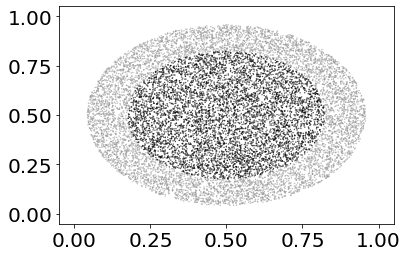

In [10]:
fig, ax = plt.subplots()

ax.scatter(data['x0'].values, data['x1'].values, c=data['C'].values, cmap = 'Greys', s=0.1)

fig.savefig(path_figs+'data.jpeg',bbox_inches='tight', pad_inches = 0)

plt.show()

### Apply box clustering to use for the adaptive algorithm

In [11]:
col_select = ['x0', 'x1']
data,_ = box_clustering(data.copy(), clusters = clusters, col_select = col_select )

In [12]:
data.head(3)

,x0,x1,C,Treatment,Y,Ycf,ITE,Box-Cluster
0,0.548814,0.715189,2,0,7.228883,0.582488,-6.646395,83
1,0.602763,0.544883,2,0,-7.333669,-6.142980,1.190689,61
2,0.423655,0.645894,2,0,-4.247772,3.155313,7.403085,81


In [13]:
%%time
adaptive_ite_name = 'ITE-ADAPTIVE'
ite_old_name = 'ITE'
data2 = adaptive_box(data.copy(), clusters = clusters, ite_old_name = ite_old_name,
                    ite_name = adaptive_ite_name, col_select = col_select)

CPU times: user 2min 54s, sys: 27.9 ms, total: 2min 54s
Wall time: 2min 54s


### Speed up

from numba import jit
import numba as nb
_spec = [
    ('data_groups2', nb.types.List(nb.types.Array(nb.types.float64, 3, 'C')))
    
]
def adaptive_box2(data, clusters = 100, cluster_name ='Box-Cluster',ite_old_name = 'ITE', ite_name = 'Adaptive-ite',
                   min_support=0, max_support=1, col_select = None, fit_kwargs = {}):
    
    """
    data: pd.dataFrame with one column containing the box-clustering (box# the datapoint belongs to)
    clusters: number of total boxes in the clustering
    cluster_name: the name of the box clustering column in data
    ite_old_name: name of the current calculated ite for a point
    ite_name: the name the new adaptive ite will take
    min_support: support of the data
    max_support the max support of the data
    col_select: the columns containing the data points
    fit_kwargs: Nothing just for framework consistency
    """
    
    #add the new column to data
    data[ite_name] = 0
    
    #grouped by cluster data
   #data_groups = data.set_index(cluster_name).copy()
    
    # groups dictionary
    names = col_select + [ite_old_name]
    data_groups2 = data.groupby(cluster_name, 
                                 sort = True).apply(lambda x: x[['x0','x1','ITE']].values.astype(np.float64)).values
    
    data_groups2 = list(data_groups2)
    #new ites
    new_ites = np.zeros(len(data)).astype(np.float64)
    
    #take datapoints
    values = data[col_select].values.astype(np.float64)
    
    #feature length
    f = values.shape[1]
    
    
    
    dims = values.shape[1]
    #boxes_per_dimension
    grid_length = int(clusters**(1/dims))
    
    #espilon side of the box
    box_length = (max_support-min_support)/grid_length
    
    #array to put (x,y) pair to the correct box number
    pivot_array = np.array([grid_length**i for i in range(dims)]).astype(np.float64)
    
    offset = [-box_length, 0, box_length]
    offset_np = np.zeros([9,2])
    cn = 0
    for offs_x in offset:
        for offs_y in offset:
            offset_np[cn] = np.array([offs_x,offs_y])
            cn += 1
    offset_np = offset_np.astype(np.float64)           
    #for each point in data
    print(type(data_groups2), data_groups2[0].dtype, new_ites.dtype, values.dtype, pivot_array.dtype,
          offset_np.dtype)
    new_ites = adapt_numba(data_groups2,new_ites, values, pivot_array,
                           offset_np, max_support, 
                           min_support, box_length, dims)
    
    data[ite_name]  = new_ites  
    return data

@jit(nopython = True)
def adapt_numba(data_groups2, new_ites, values, pivot_array,
                offset_np, max_support, min_support, box_length, dims):
    for  i in range(values.shape[0]):
        #if i%50 == 0:
           # print(i)
        box_numbers = set()
        for k in range(offset_np.shape[0]):
            xnew = values[i] + offset_np[k]
            #support check
            supp_check = np.all((xnew >= min_support) & (xnew <= max_support))
            if not supp_check:
                continue
            #get box number   
            xnew_grid_coord = np.floor((xnew-min_support)/box_length).astype(np.int64)
            #print(xnew_grid_coord.shape, pivot_array.shape)

            bn = np.sum(xnew_grid_coord*pivot_array)#.astype(np.int64)
            bn = int(bn)
            box_numbers.add(bn)
       # print(box_numbers, i)
        #candidates = data_groups.loc[box_numbers,col_select+[ite_old_name ]].values
        count = 0
        avg = 0
        box_numbers = list(box_numbers)

        for bx in box_numbers:
            for  j in range(data_groups2[bx].shape[0]):
                cand = data_groups2[bx][j]
                vals = np.abs(values[i]-cand[0:dims])
                if np.all(vals <= box_length):
                    avg += cand[-1]
                    count+=1
        
        new_ite = avg/count
        new_ites[i] = new_ite
        
    return new_ites



In [14]:
def adaptive_box3(data, clusters = 100, cluster_name ='Box-Cluster',ite_old_name = 'ITE', ite_name = 'Adaptive-ite',
                   min_support=0, max_support=1, col_select = None, fit_kwargs = {}):
    
    """
    data: pd.dataFrame with one column containing the box-clustering (box# the datapoint belongs to)
    clusters: number of total boxes in the clustering
    cluster_name: the name of the box clustering column in data
    ite_old_name: name of the current calculated ite for a point
    ite_name: the name the new adaptive ite will take
    min_support: support of the data
    max_support the max support of the data
    col_select: the columns containing the data points
    fit_kwargs: Nothing just for framework consistency
    """
    
    #add the new column to data
    data[ite_name] = 0
    
    #grouped by cluster data
    data_groups = data.set_index(cluster_name).copy()
    
    #take datapoints
    values = data[col_select].values
    dims = values.shape[1]
    new_ites= np.zeros(len(data))
    
    #boxes_per_dimension
    grid_length = int(clusters**(1/dims))
    
    #espilon side of the box
    box_length = (max_support-min_support)/grid_length
    
    #array to put (x,y) pair to the correct box number
    pivot_array = np.array([grid_length**i for i in range(dims)])
    
    offset = [-box_length, 0, box_length]
    offset_np = np.zeros([9,2])
    cn = 0
    for offs_x in offset:
        for offs_y in offset:
            offset_np[cn] = np.array([offs_x,offs_y])
            cn += 1
                
    #for each point in data
    for  i in range(len(values)):
        #if i%50 == 0:
           # print(i)
        box_numbers = set()
        for offs in offset_np:
            xnew = values[i] + offs
            #support check
            supp_check = np.all((xnew >= min_support) & (xnew <= max_support))
            if not supp_check:
                continue
            #get box number   
            xnew_grid_coord = np.floor((xnew-min_support)/box_length).astype(int)
            #print(xnew_grid_coord.shape, pivot_array.shape)

            bn = np.sum(xnew_grid_coord*pivot_array).astype(int)

            box_numbers.add(bn)
        
       # print(box_numbers, i)
        candidates = data_groups.loc[box_numbers,col_select+[ite_old_name ]].values
        #print(values[i].shape, candidates[:,0:dims].shape)
        in_box = np.all((np.abs(values[i]-candidates[:,0:dims]) <= box_length), axis = 1)
        #print(in_box)
        #print(len(candidates), candidates[in_box][:,-1].shape)
        new_ite = np.mean(candidates[in_box][:,-1])
        new_ites[i] = new_ite
        #print(new_ite)
        
    
    data[ite_name] = new_ites
    return data




In [15]:
%%time
adaptive_ite_name = 'ITE-ADAPTIVE'
ite_old_name = 'ITE'
data4 = adaptive_box3(data.copy(), clusters = clusters, ite_old_name = ite_old_name,ite_name = adaptive_ite_name, col_select = col_select)

CPU times: user 1min 10s, sys: 13.6 ms, total: 1min 10s
Wall time: 1min 10s


In [16]:
print(np.abs((data4['ITE-ADAPTIVE'] - data2['ITE-ADAPTIVE'])))

0        4.440892e-16
1        1.554312e-15
2        4.440892e-16
3        6.661338e-16
4        1.110223e-16
             ...     
19995    1.332268e-15
19996    5.551115e-16
19997    8.881784e-16
19998    4.163336e-17
19999    1.221245e-15
Name: ITE-ADAPTIVE, Length: 20000, dtype: float64


In [35]:
%%time
adaptive_ite_name = 'ITE-ADAPTIVE'
ite_old_name = 'ITE'
data3 = adaptive_box2(data.copy(), clusters = clusters, ite_old_name = ite_old_name,ite_name = adaptive_ite_name, col_select = col_select)

CPU times: user 7.39 s, sys: 35.3 ms, total: 7.43 s
Wall time: 7.36 s


In [18]:
print(all(data3['ITE-ADAPTIVE'] == data2['ITE-ADAPTIVE']))
print(np.abs((data3['ITE-ADAPTIVE'] - data2['ITE-ADAPTIVE'])))

False
0        0.000000e+00
1        0.000000e+00
2        0.000000e+00
3        3.330669e-16
4        3.330669e-16
             ...     
19995    2.220446e-16
19996    6.661338e-16
19997    0.000000e+00
19998    8.326673e-17
19999    1.110223e-16
Name: ITE-ADAPTIVE, Length: 20000, dtype: float64


In [19]:
%prun  adaptive_box2(data.copy(), clusters = clusters, ite_old_name = ite_old_name,ite_name = adaptive_ite_name, col_select = col_select)

#print(all(data3['ITE-ADAPTIVE'] == data2['ITE-ADAPTIVE']))

In [20]:
data2.head(3)

,x0,x1,C,Treatment,Y,Ycf,ITE,Box-Cluster,ITE-ADAPTIVE
0,0.548814,0.715189,2,0,7.228883,0.582488,-6.646395,83,1.442208
1,0.602763,0.544883,2,0,-7.333669,-6.142980,1.190689,61,1.994832
2,0.423655,0.645894,2,0,-4.247772,3.155313,7.403085,81,1.492654


In [21]:
clusts = 3
np.random.seed(seed = 0)
data2,_ = kmeans_clustering(data2, clusters = clusts, cluster_name = 'ITE-ADAPTIVE-3CLUST',
                           col_select = [adaptive_ite_name] )
np.random.seed(seed = 0)
data3,_ = kmeans_clustering(data3, clusters = clusts, cluster_name = 'ITE-ADAPTIVE-3CLUST',
                           col_select = [adaptive_ite_name] )

np.random.seed(seed = 0)
data4,_ = kmeans_clustering(data4, clusters = clusts, cluster_name = 'ITE-ADAPTIVE-3CLUST',
                           col_select = [adaptive_ite_name] )

### Adaptive ITES values scatter plot

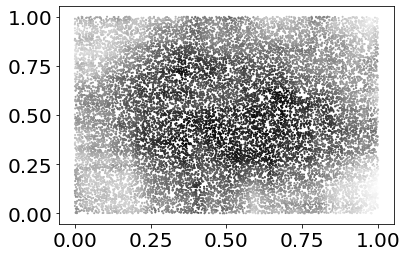

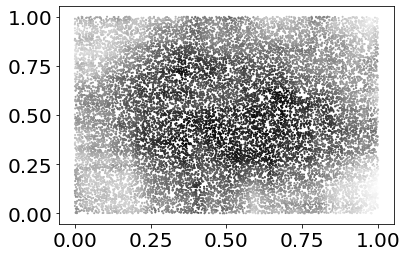

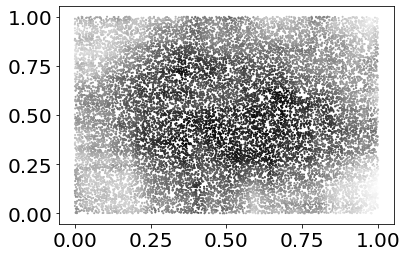

In [22]:
fig, ax = plt.subplots()

sc = ax.scatter(data2['x0'].values, data2['x1'].values, c=data2[adaptive_ite_name], cmap = 'Greys', s = 1)


fig, ax = plt.subplots()

sc = ax.scatter(data3['x0'].values, data3['x1'].values, c=data3[adaptive_ite_name], cmap = 'Greys', s = 1)


fig, ax = plt.subplots()

sc = ax.scatter(data4['x0'].values, data4['x1'].values, c=data4[adaptive_ite_name], cmap = 'Greys', s = 1)

### 2 Clustering of Adaptive ites

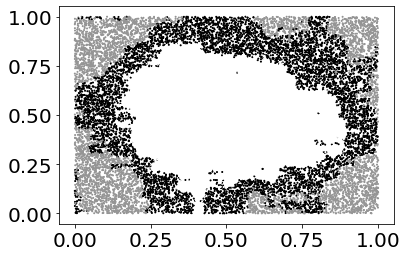

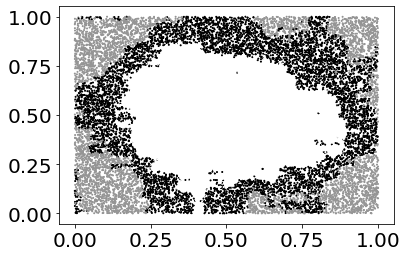

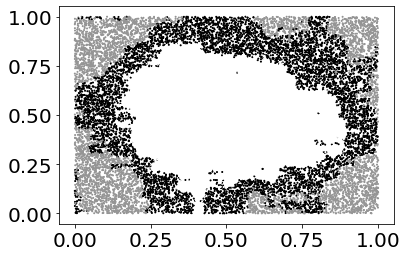

In [23]:
fig, ax = plt.subplots()

sc = ax.scatter(data2['x0'].values, data2['x1'].values, c=data2['ITE-ADAPTIVE-3CLUST'], cmap = 'Greys', s = 1)

fig, ax = plt.subplots()

sc = ax.scatter(data3['x0'].values, data3['x1'].values, c=data3['ITE-ADAPTIVE-3CLUST'], cmap = 'Greys', s = 1)

fig, ax = plt.subplots()

sc = ax.scatter(data4['x0'].values, data4['x1'].values, c=data4['ITE-ADAPTIVE-3CLUST'], cmap = 'Greys', s = 1)


### Histogram of Adaptive Ites

/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


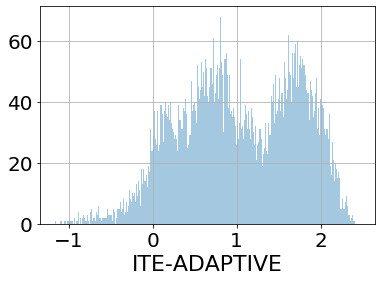

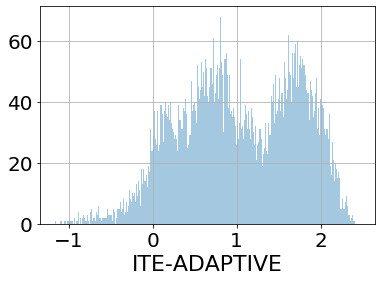

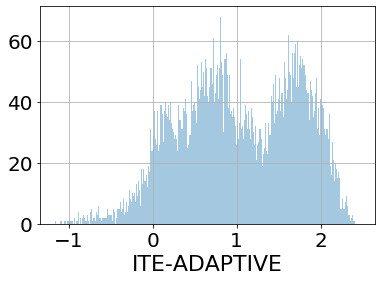

In [24]:
fig, ax = plt.subplots()

ax = sns.distplot(data2[adaptive_ite_name],  bins=800, kde = False,ax = ax)
ax.grid(visible = True)


fig, ax = plt.subplots()

ax = sns.distplot(data3[adaptive_ite_name],  bins=800, kde = False,ax = ax)
ax.grid(visible = True)


fig, ax = plt.subplots()

ax = sns.distplot(data4[adaptive_ite_name],  bins=800, kde = False,ax = ax)
ax.grid(visible = True)
#ax.set_xlim(-2,2)

In [25]:
def MAE_pd(group, name1,name2,column_name):
    
    group[column_name] = np.abs(group[name1].values-group[name2].mean())
    return group
    
    

In [26]:
ite_column = 'ITE-ADAPTIVE'
clust2 = 'ITE-ADAPTIVE-3CLUST'

data2 = data2.groupby(clust2).apply(lambda x: MAE_pd(x, 'C', ite_column, clust2+'-err-GDBR'))

data3 = data3.groupby(clust2).apply(lambda x: MAE_pd(x, 'C', ite_column, clust2+'-err-GDBR'))

data4 = data4.groupby(clust2).apply(lambda x: MAE_pd(x, 'C', ite_column, clust2+'-err-GDBR'))

In [27]:
data2

,x0,x1,C,Treatment,Y,Ycf,ITE,Box-Cluster,ITE-ADAPTIVE,ITE-ADAPTIVE-3CLUST,ITE-ADAPTIVE-3CLUST-err-GDBR
0,0.548814,0.715189,2,0,7.228883,0.582488,-6.646395,83,1.442208,0,0.242838
1,0.602763,0.544883,2,0,-7.333669,-6.142980,1.190689,61,1.994832,0,0.242838
2,0.423655,0.645894,2,0,-4.247772,3.155313,7.403085,81,1.492654,0,0.242838
3,0.437587,0.891773,1,0,-3.197153,6.221109,9.418262,103,0.825353,2,0.135283
4,0.963663,0.383442,0,0,3.046737,-1.946728,-4.993465,54,0.843827,2,0.864717
...,...,...,...,...,...,...,...,...,...,...,...
19995,0.466430,0.770390,2,1,8.168459,-0.998147,9.166606,93,1.729822,0,0.242838
19996,0.904429,0.317742,1,0,6.274208,0.881694,-5.392514,42,0.985907,2,0.135283
19997,0.540895,0.668383,2,0,15.789581,-1.774380,-17.563961,82,1.435844,0,0.242838
19998,0.994911,0.588224,0,0,-0.885966,-7.964905,-7.078939,76,-0.110920,1,0.113822


ite_column = 'ITE'

data = data.groupby(clust2).apply(lambda x: MAE_pd(x, 'C', ite_column, clust2+'-err-True-ITE'))

In [28]:
errors2 = data2.describe().loc[['mean', 'std'], [col for col in data2.columns if 'err' in col]].T

errors3 = data3.describe().loc[['mean', 'std'], [col for col in data3.columns if 'err' in col]].T

errors4 = data4.describe().loc[['mean', 'std'], [col for col in data4.columns if 'err' in col]].T

In [29]:
errors2.sort_values(by = 'mean')

,mean,std
ITE-ADAPTIVE-3CLUST-err-GDBR,0.318443,0.287828


In [30]:
errors3.sort_values(by = 'mean')

,mean,std
ITE-ADAPTIVE-3CLUST-err-GDBR,0.318443,0.287828


In [31]:
errors4.sort_values(by = 'mean')

,mean,std
ITE-ADAPTIVE-3CLUST-err-GDBR,0.318443,0.287828


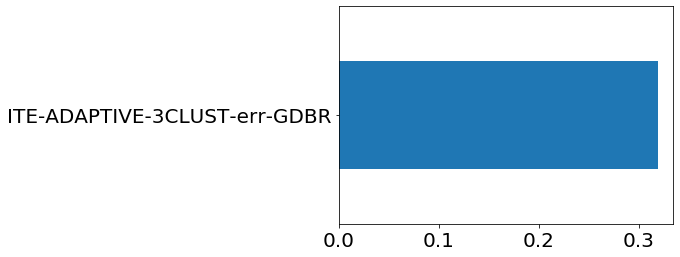

In [32]:
ax = errors2['mean'].sort_values().plot.barh()
plt.show()

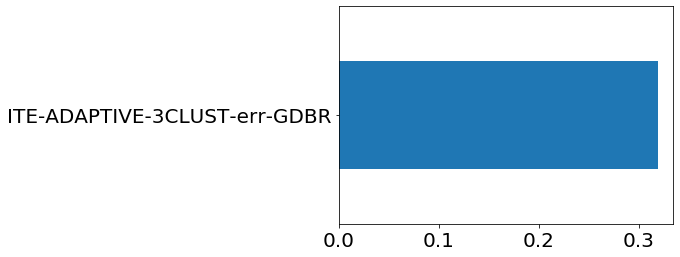

In [33]:
ax = errors3['mean'].sort_values().plot.barh()
plt.show()

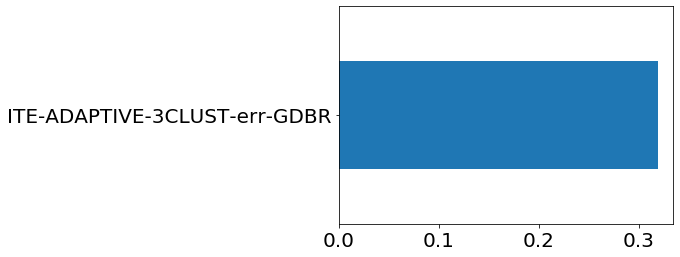

In [34]:
ax = errors4['mean'].sort_values().plot.barh()
plt.show()